In [32]:
#PROGRAMA PARA DETECÇÃO DE FONTES
from astropy.stats import sigma_clipped_stats
import scipy.ndimage as ndi
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

In [33]:
#Importar imagem
GHII = 'UM455_full.fits'
fits.info(GHII)

data = fits.open(GHII)
data = data[0].data

#Estatística de sigma cortado
mean , median , std = sigma_clipped_stats ( data , sigma = 3. )  
print (( mean , median , std ))  #média, mediana e desvio padrão

Filename: UM455_full.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     215   (996, 2048)   float32   
(0.30143327, 0.30101496, 0.02366888)


<IPython.core.display.Javascript object>


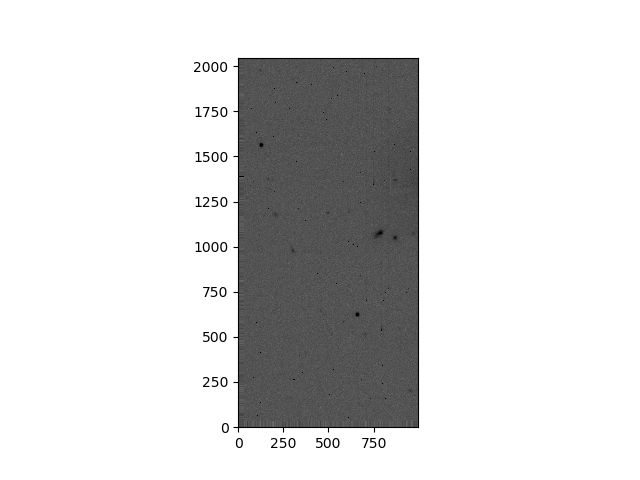

In [34]:
#Plot da Imagem
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

plt.imshow(data, origin='lower', cmap='gray_r', norm=LogNorm(vmin=0.025, vmax=1))

<IPython.core.display.Javascript object>


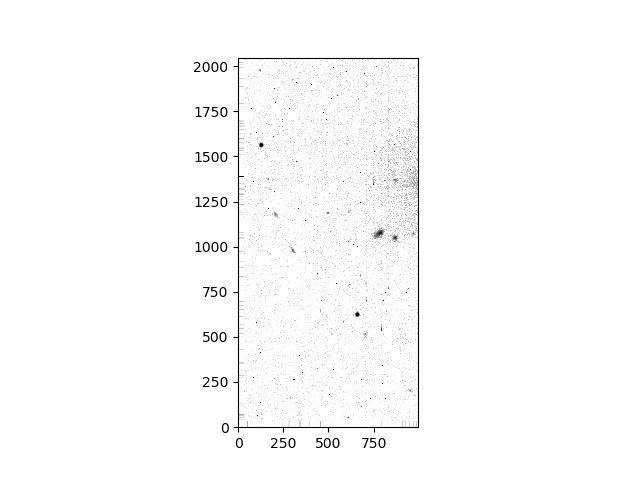

In [35]:
#Plot da imagem com background subtraido
%matplotlib notebook
data_sub = data - median
plt.imshow(data_sub, origin='lower', cmap='gray_r', norm=LogNorm(vmin=0.025, vmax=1))

In [36]:
#Subtração do background e DAOStarFinder (implementação do algoritmo DAOFIND) para encontrar as estrelas na imagem.
from photutils import DAOStarFinder
daofind = DAOStarFinder(fwhm=1.0, threshold=5.*std) #Estrelas com FWHMs de 3 pixels e picos aprox. 5sigma acima plano de fundo
sources = daofind(data - median)  
for col in sources.colnames:  
    sources[col].info.format = '%.4g'  # for consistent table output
print(sources)  


 id xcentroid ycentroid sharpness roundness1 ... npix sky  peak   flux   mag  
--- --------- --------- --------- ---------- ... ---- --- ------ ----- -------
  1     677.9     32.71    0.9477     0.1102 ...   25   0  1.826  13.7  -2.842
  2     270.4     46.62    0.9415    -0.1128 ...   25   0  1.512 11.14  -2.617
  3     137.8     48.65    0.9502     0.2496 ...   25   0  1.911 14.47  -2.902
  4     142.8     52.77    0.9492     0.2247 ...   25   0  2.825 21.35  -3.324
  5     611.1     50.85    0.9167  -0.008266 ...   25   0  3.781  26.1  -3.542
  6     452.7     58.22     0.939     0.4415 ...   25   0  1.632 11.89  -2.688
  7     107.6     62.78    0.9505      0.175 ...   25   0  2.309 17.42  -3.103
  8       438     65.85    0.9472     0.1872 ...   25   0  1.356 10.18   -2.52
  9     888.2     66.85    0.9208    -0.4126 ...   25   0 0.8452 5.987  -1.943
 10     945.7      74.3    0.9346     0.4396 ...   25   0  1.544 11.03  -2.606
...       ...       ...       ...        ... ...  ..

<IPython.core.display.Javascript object>


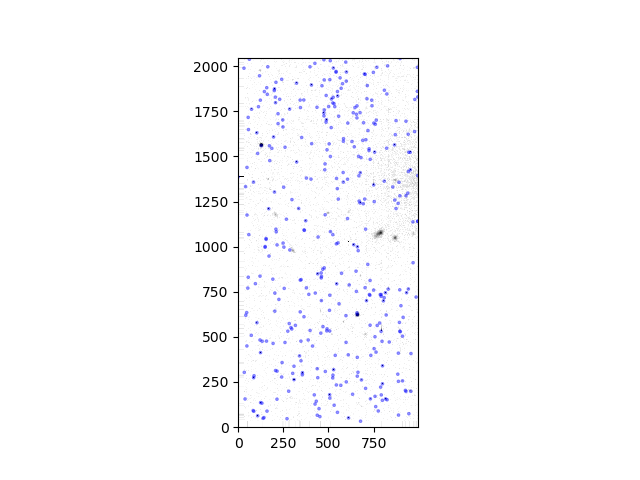

In [37]:
#Plot final da imagem com a DETECÇÃO das estrelas
%matplotlib notebook
import numpy as np
from astropy.visualization import SqrtStretch #visualizador raiz
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture
positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.)
norm = ImageNormalize(vmin=0.025, vmax=1,stretch=SqrtStretch())
plt.imshow(data_sub,  origin='lower', cmap='Greys', norm=norm)
apertures.plot(color='Blue', lw=1.5, alpha=0.5)

In [38]:
#DETECÇÃO DE PICOS 
from photutils import find_peaks
import photutils

#Estatística de sigma cortado da imagem subtraida do fundo
mean , median , std = sigma_clipped_stats ( data_sub , sigma = 5. )  
print (( mean , median , std ))  #média, mediana e desvio padrão

#Calcule uma imagem de limite em pixel que pode ser usada para detectar fontes.
threshold = photutils.detect_threshold(data_sub, snr=5.0, background=None, error=None) #error=None; Se None , um valor eficaz de fundo escalar será estimado usando estatísticas cortadas por sigma. 

tbl = find_peaks(data_sub, threshold, box_size=11)
tbl['peak_value'].info.format = '%.5g'  # for consistent table output
print(tbl[:10])  # print only the first 10 peaks

(0.0007725576288066804, 0.00012359023094177246, 0.024574028328061104)
x_peak y_peak peak_value
------ ------ ----------
   346      0     2.3978
   346      1     2.3978
   346      2     2.3978
   346      3     2.3978
   346      4     2.3978
   346      5     2.3978
   346      6     2.3978
   346      7     2.3978
   346      8     2.3978
   346      9     2.3978


<IPython.core.display.Javascript object>


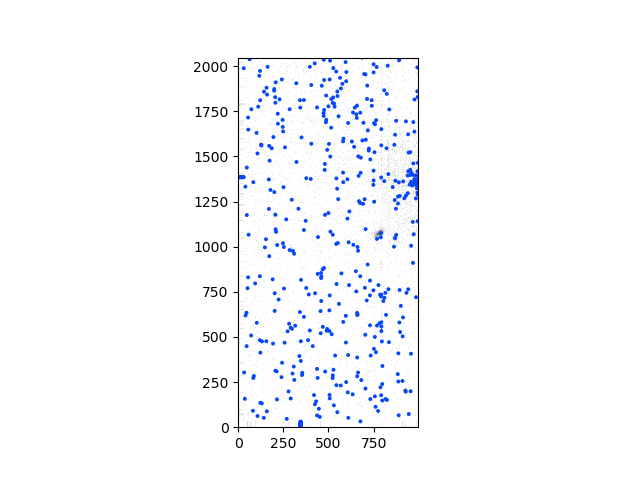

(0, 2047)

In [39]:
#PLot dos PICOS DETECTADOS
%matplotlib notebook

import numpy as np
from astropy.visualization import simple_norm

from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture

positions = np.transpose((tbl['x_peak'], tbl['y_peak']))
apertures = CircularAperture(positions, r=5.)
norm = simple_norm(data_sub, 'sqrt', percent=99.9)
plt.imshow(data_sub, cmap='Greys', origin='lower',vmin=0.025, vmax=1, norm=norm)
apertures.plot(color='#0547f9', lw=1.5)
plt.xlim(0, data.shape[1]-1)
plt.ylim(0, data.shape[0]-1)